 # Modelling tests neural network



### Table of Contents

* [1. Modeles](#modeles)
* [2. Fonctions d'entrainement](#functions)
* [3. Entrainements sur 13000 signaux par classe](#sig13000)
    * [Modele 1](#m1_13000)
    * [Modele 2](#m2_13000)
    * [Modele 3](#m3_13000)
* [4. Entrainements sur 50000 signaux par classe](#sig50000)
    * [Modele 1](#m1_50000)
    * [Modele 2](#m2_50000)
    * [Modele 3](#m3_50000)
* [5. Entrainements sur smote seul](#smote)
* [6. Resultats finaux](#results)




je teste ici des modèles de réseaux de neurones d'abord sur les signaux brutes
je ne détaille pas toutes les expériences faites.

Sur une base suréchantillonée de 13000 signaux par classe, les modèles ANN ne marchent pas très bien.
il y a trop de signaux normaux classés en anormaux.

De plus, il y a un décallage avec le train et le test. la loss sur le train continue de descendre alors que sur le test, on arrive à un plateau.
Il n'y a pas besoins de faire énormément d'itération pour arriver à ce plateau.
A partir de la le modèle s'overfit.

Par conséquent j'ai esssayé d'abord d'augementer la base avec 60000 signaux par classe et cela améliore nettement les résultats


j'ai testé plusieeurs types de modèles constituées de couches de réseaux de neurones. avec des hidden layers de mêmes nombre de neurones ou des hidden layers avec un nombre de neurones divisé par 2 à chaque couches. je fais aussi varier l'activation.

In [1]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim
import joblib
from sklearn.model_selection import train_test_split

## 1. Modèles <a class="anchor" name="modeles"></a>

In [2]:

def modele_type_1(n,activation=nn.Sigmoid,input_shape=187,device='cpu'):
    model = nn.Sequential(
       nn.Linear(input_shape, n),
       activation(),
       nn.Linear(n, n),
       activation(),
       nn.Linear(n, n // 2),
       activation(),  
       nn.Linear(n // 2, 5)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
def modele_type_2(n,activation=nn.Sigmoid,input_shape=187,device='cpu'):
    model = nn.Sequential(
       nn.Linear(input_shape, n),
       activation(),
       nn.Linear(n, n),
       activation(),
       nn.Linear(n, n),
       activation(),
       nn.Linear(n , 5)
    )   
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model

def modele_type_3(n,p,activation=nn.Sigmoid,input_shape=187,device='cpu'):
    model = nn.Sequential()
    model.add_module("dense_start", nn.Linear(input_shape, n))
    model.add_module("act_start", activation())

    for couche in range(p):
        model.add_module("dense%d" %couche, nn.Linear(n, n))
        model.add_module("act%d" %couche, activation())
    model.add_module("dense_end", nn.Linear(n, 5))
    #model.add_module("act_start", nn.Sigmoid())
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model


## 2. fonction d'entrainement et de test <a class="anchor" name="functions"></a>

j'utilise volontairement la précision 'macro' puisque la base de test est elle aussi totalement déséquilibrée. je voudrais que les anormaux ne soient pas classé en classe normal. 

si l'on prend la précision classique, j'ai des valeurs qui dépassent 90% alors que plus de la moitié des classe 1 est classée en 0
il faudra envisagé une sortie de l'entrainement si cette précision macro atteint une certaine valeur.

la précision marco du coup va minimiser l'impact d'avoir bien classé un grand nmbre de classe 0

il faudrait faire une base de cross - validation

In [3]:
def evaluate_model(model, test_set):
    X, y_true = test_set[:]
   
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    
    with torch.no_grad():
        # Prédiction du modèle pour un batch donné
        y_pred = model(X)

    loss_test = criterion(y_pred, y_true)
    
    y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
    y_true = y_true.numpy()
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test.item()
    
def train_a_model(model,train_loader,test_set,epochs = 100,lr=1e-3,device='cpu',outmodelname=None):

    best_accuracy = 0
   
    optimizer = optim.Adam(model.parameters(), lr)

    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    loss_list_test = []

    accuracy_list = []
    start = time.time()
    
    for epoch in range(epochs):
        # Dans ce mode certaines couches du modèle agissent différemment
        model.train()
        loss_total = 0
        
        for batch in train_loader:
            # Batch de données
            X_batch, y_batch = batch
            
            # Device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Gradient mis 0
            model.zero_grad()
    
            # Calcul de prédiction
            y_pred = model(X_batch)
    
            # Calcul de la fonction de perte
            loss = criterion(y_pred, y_batch)
    
            # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
            loss.backward()
            
            # Clipper le gradient entre 0 et 1 pour plus de stabilité
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Descente de gradient : actualisation des paramètres
            optimizer.step()
            
            loss_total += loss.item()

        y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
        if accuracy > best_accuracy and outmodelname is not None:
            joblib.dump(model, outmodelname)
            print('save model')
            best_accuracy = accuracy
        loss_list.append(loss_total/len(train_loader))
        loss_list_test.append(loss)
        accuracy_list.append(accuracy)
        print(f"Epoch : {epoch+1}/{epochs} -- Training loss {loss_total/len(train_loader)}, --- Val loss {loss}, --- accuray : {accuracy}, --- recall : {recall}")
    
    print("hello")
    end = time.time()
    
    print("execution time: ",end - start)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss_list,label='loss train')
    ax.plot(loss_list_test,label='loss test')
    ax.legend()

    table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
    print(table)

    print(classification_report(y_true, y_pred))

## 3. base de données à 13000 signaux par classe  <a class="anchor" name="sig13000"></a>

### creation de la base <a class="anchor" id="dataset"></a>

base sur echantillonée: N signaux par classe=13000

In [4]:
if not os.path.isfile('../data/processed/mitbih_train_smote_perturb_13000.csv'):
    Xo,yo = load_balanced.load_balanced_data(method='smote-perturb',n_normal=13000,
                       smote_perturb_smote_ratio=0.5)
    pd.DataFrame(np.concatenate((Xo,np.expand_dims(yo,axis=1)),axis=1)).to_csv('../data/processed/mitbih_train_smote_perturb_13000.csv',index=None,header=None)

calcul des features sur ces bases

In [5]:

if not os.path.isfile('../data/processed/features_mitbih_train_smote_perturb_13000.csv'):
    from features import build_features
    build_features.transform_inputs(files=['../data/processed/mitbih_train_smote_perturb_13000.csv'],
                     outdir = '../data/processed',
                    applyfilter='gaussian',
                      paramfilter=1,
                      Fs=125,
                      nech=6)


### chargement si précalculée

In [6]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_13000.csv')
X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')

X_train, X_cross, y_train, y_cross = train_test_split(X_train, y_train,random_state=44,test_size = 0.05)
train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
cross_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))

test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))

train_loader = DataLoader(train_set, batch_size=30, shuffle=True)

### 3.1 modèle type 1 example: couches de 64 puis 32  <a class="anchor" name="m1_13000"></a>

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,032
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            4,160
├─Sigmoid: 1-4                           --
├─Linear: 1-5                            2,080
├─Sigmoid: 1-6                           --
├─Linear: 1-7                            165
Total params: 18,437
Trainable params: 18,437
Non-trainable params: 0
save model
Epoch : 1/50 -- Training loss 0.9233780439441907, --- Val loss 0.6873425245285034, --- accuray : 0.7365413730130606, --- recall : 0.7382499484276375
save model
Epoch : 2/50 -- Training loss 0.6235826173819866, --- Val loss 0.5834727883338928, --- accuray : 0.7855833538109017, --- recall : 0.7788637287172284
save model
Epoch : 3/50 -- Training loss 0.5373025355682378, --- Val loss 0.4986056089401245, --- accuray : 0.8333591789524541, --- recall : 0.8213751224238133
save model
Epoch : 4/50 -- Training loss 0.47305043579421613, --- Val loss 0.44291

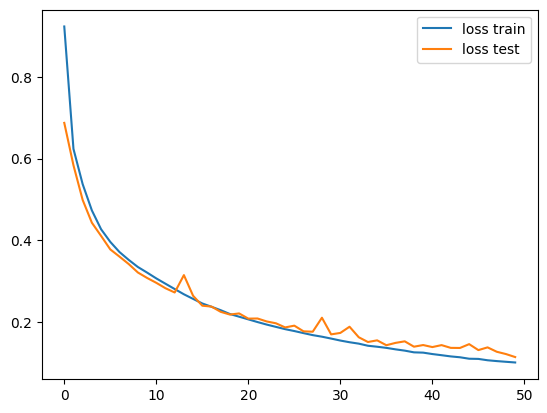

In [7]:
model = modele_type_1(64)
train_a_model(model,train_loader,cross_set,epochs = 50,lr=1e-3,outmodelname='../models/model_DNN_1.pkl')

In [8]:
model=joblib.load('../models/model_DNN_1.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          16621  746   298  321   132
1             66  465    18    3     4
2             24   15  1365   38     6
3              6    2    11  143     0
4             10    6    13    2  1577
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     18118
           1       0.38      0.84      0.52       556
           2       0.80      0.94      0.87      1448
           3       0.28      0.88      0.43       162
           4       0.92      0.98      0.95      1608

    accuracy                           0.92     21892
   macro avg       0.67      0.91      0.74     21892
weighted avg       0.95      0.92      0.93     21892



trop de classes 0 sont prédits en 1 2, 3 ,4. une piste d'amélioration pour ce modèle est d'aller voir ces signaux. sinon le reste ca va
ce qui en soit se traduit par envoyer des non malades faire de plus amples examens donc cela n'est pas si grave.

### 3.2 modèle type 2 example: couches de 64 puis 64 puis 64 neurones <a class="anchor" name="m2_13000"></a>

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,032
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            4,160
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 20,677
Trainable params: 20,677
Non-trainable params: 0
save model
Epoch : 1/25 -- Training loss 0.5579697583567291, --- Val loss 0.39215314388275146, --- accuray : 0.8625150033494933, --- recall : 0.8563085308047199
save model
Epoch : 2/25 -- Training loss 0.34004861917735707, --- Val loss 0.32437342405319214, --- accuray : 0.8808609082171834, --- recall : 0.8761377133529326
save model
Epoch : 3/25 -- Training loss 0.2653310772179906, --- Val loss 0.2401491105556488, --- accuray : 0.9116374979013366, --- recall : 0.9109788567302808
save model
Epoch : 4/25 -- Training loss 0.21963776346031919, --- Val loss 0.22

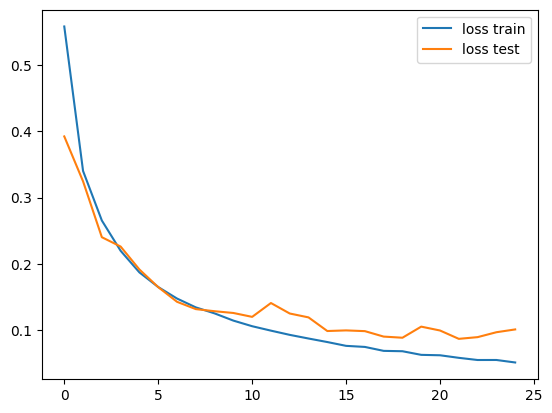

In [9]:
model = modele_type_2(64,activation=nn.ReLU)
train_a_model(model,train_loader,cross_set,epochs = 25,lr=1e-3,outmodelname='../models/model_DNN_2.pkl')

In [10]:
model=joblib.load('../models/model_DNN_2.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17171  480   217  131   119
1             76  462     9    4     5
2             46   15  1351   29     7
3             10    1    10  140     1
4             11    6     6    2  1583
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     18118
           1       0.48      0.83      0.61       556
           2       0.85      0.93      0.89      1448
           3       0.46      0.86      0.60       162
           4       0.92      0.98      0.95      1608

    accuracy                           0.95     21892
   macro avg       0.74      0.91      0.80     21892
weighted avg       0.96      0.95      0.95     21892



la même chose 

### 3.3 modèle type 3 example: 5 couches cachées de 32 neurones <a class="anchor" name="m3_13000"></a>

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,032
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            4,160
├─Sigmoid: 1-4                           --
├─Linear: 1-5                            4,160
├─Sigmoid: 1-6                           --
├─Linear: 1-7                            4,160
├─Sigmoid: 1-8                           --
├─Linear: 1-9                            4,160
├─Sigmoid: 1-10                          --
├─Linear: 1-11                           4,160
├─Sigmoid: 1-12                          --
├─Linear: 1-13                           325
Total params: 33,157
Trainable params: 33,157
Non-trainable params: 0
save model
Epoch : 1/25 -- Training loss 1.0729408030836487, --- Val loss 0.8231366276741028, --- accuray : 0.7126231927604678, --- recall : 0.6929225149628895
save model
Epoch : 2/25 -- Training loss 0.7857300412631718, --- Val loss 0.7283385396003723, --- accuray : 0.7408164209947095, -

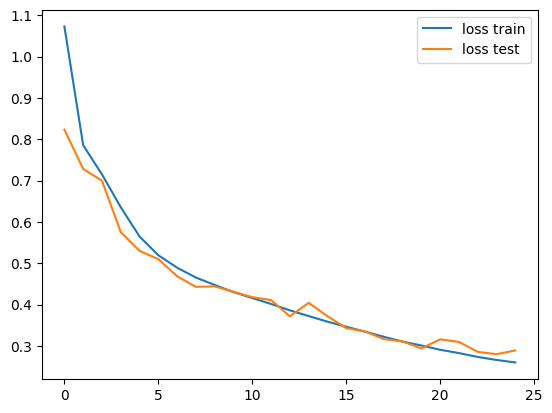

In [11]:
model = modele_type_3(64,5,activation=nn.Sigmoid)
train_a_model(model,train_loader,cross_set,epochs = 25,lr=1e-3,outmodelname='../models/model_DNN_3.pkl')

In [12]:
model=joblib.load('../models/model_DNN_3.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          16034  812   290  713   269
1             97  431     7   15     6
2             73   12  1264   84    15
3              7    0     4  151     0
4             42    1    30    4  1531
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     18118
           1       0.34      0.78      0.48       556
           2       0.79      0.87      0.83      1448
           3       0.16      0.93      0.27       162
           4       0.84      0.95      0.89      1608

    accuracy                           0.89     21892
   macro avg       0.62      0.88      0.68     21892
weighted avg       0.94      0.89      0.91     21892



### conclusion

les modèles ont du mal a classer les anormaux.il faudrait soit ajouter du dropout soit augmenter le dataset.

régularisation c'est possible?

## 4. base de données à 50000 signaux par classe <a class="anchor" name="sig50000"></a>

je ne fais pas beaucoup d'epoch car cela a tendance a overfitter

In [13]:
#X_train,y_train = load_balanced.load_balanced_data(method='smote-perturb',n_normal=50000,smote_perturb_smote_ratio=0.5)
#pd.DataFrame(np.concatenate((X_train,np.expand_dims(y_train,axis=1)),axis=1)).to_csv('../data/processed/mitbih_train_smote_perturb_50000.csv',index=None,header=None)



In [46]:
X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')


X_train, X_cross, y_train, y_cross = train_test_split(X_train, y_train,random_state=12,test_size = 0.05)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
cross_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))
test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))

train_loader = DataLoader(train_set, batch_size=30, shuffle=True)

In [15]:
pd.Series(y_train).value_counts()

3.0    47552
0.0    47524
1.0    47515
2.0    47484
4.0    47425
Name: count, dtype: int64

### 4.1 Modele 1 - 50 000 * 5 classes <a class="anchor" name="m1_50000"></a>

#### 4.1.1 : start: 128 neurons using Sigmoid activation

##### train / crossval 

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            16,512
├─Sigmoid: 1-4                           --
├─Linear: 1-5                            8,256
├─Sigmoid: 1-6                           --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/10 -- Training loss 0.574446043125966, --- Val loss 0.3893791735172272, --- accuray : 0.8673946727644519, --- recall : 0.8569661745736262
save model
Epoch : 2/10 -- Training loss 0.3380856399286858, --- Val loss 0.29982835054397583, --- accuray : 0.8890929515446733, --- recall : 0.8887145588757901
save model
Epoch : 3/10 -- Training loss 0.25559000508337215, --- Val loss 0.21668308973312378, --- accuray : 0.9224035621284254, --- recall : 0.9226301790672691
save model
Epoch : 4/10 -- Training loss 0.1983909111099902, --- Val loss 0.178

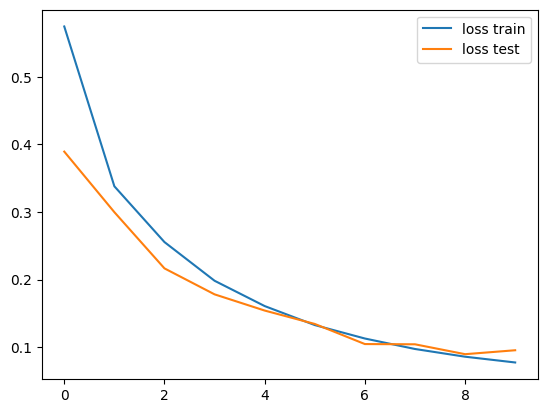

In [16]:
model = modele_type_1(128,activation=nn.Sigmoid)
train_a_model(model,train_loader,cross_set,epochs = 10,lr=1e-3,outmodelname='../models/model_DNN_1_50000_128_SIGMOID.pkl')


##### eval on test

In [17]:
model=joblib.load('../models/model_DNN_1_50000_128_SIGMOID.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17002  663   240  132    81
1             71  467     9    4     5
2             28    9  1381   26     4
3              9    0    16  137     0
4             15    8     8    0  1577
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     18118
           1       0.41      0.84      0.55       556
           2       0.83      0.95      0.89      1448
           3       0.46      0.85      0.59       162
           4       0.95      0.98      0.96      1608

    accuracy                           0.94     21892
   macro avg       0.73      0.91      0.79     21892
weighted avg       0.96      0.94      0.95     21892



#### 4.1.2 : start: 128 neurons using ReLU activation

##### train / crossval 

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─ReLU: 1-2                              --
├─Linear: 1-3                            16,512
├─ReLU: 1-4                              --
├─Linear: 1-5                            8,256
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/10 -- Training loss 0.29514669601565413, --- Val loss 0.1927454173564911, --- accuray : 0.9323700255893081, --- recall : 0.9297041654449829
save model
Epoch : 2/10 -- Training loss 0.12989462109965372, --- Val loss 0.10412860661745071, --- accuray : 0.962761302095488, --- recall : 0.962807839029673
save model
Epoch : 3/10 -- Training loss 0.09346511392133988, --- Val loss 0.07648777216672897, --- accuray : 0.972990088951741, --- recall : 0.9729503013560015
save model
Epoch : 4/10 -- Training loss 0.07379085494851646, --- Val loss 0.06

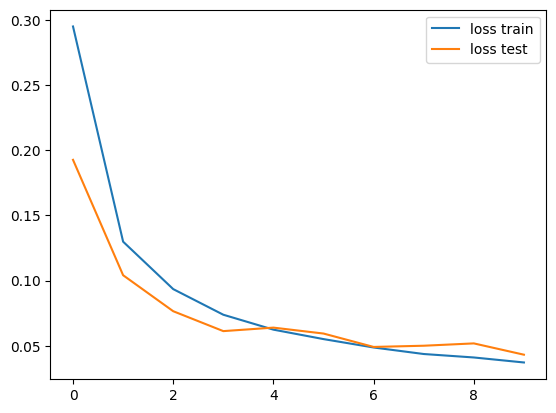

In [18]:
model = modele_type_1(128,activation=nn.ReLU)
train_a_model(model,train_loader,cross_set,epochs = 10,lr=1e-3,outmodelname='../models/model_DNN_1_50000_128_RELU.pkl')


##### eval on test

In [19]:
model=joblib.load('../models/model_DNN_1_50000_128_RELU.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17621  270    61  137    29
1             82  464     6    2     2
2             48    8  1369   19     4
3             14    1    12  135     0
4             17    3     3    0  1585
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.62      0.83      0.71       556
           2       0.94      0.95      0.94      1448
           3       0.46      0.83      0.59       162
           4       0.98      0.99      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.80      0.91      0.84     21892
weighted avg       0.97      0.97      0.97     21892



#### 4.1.3 : start: 128 neurons using ReLU activation : use the test set as crossval. Not fair. just to check

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─ReLU: 1-2                              --
├─Linear: 1-3                            16,512
├─ReLU: 1-4                              --
├─Linear: 1-5                            8,256
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/10 -- Training loss 0.3021145174867988, --- Val loss 0.2848472595214844, --- accuray : 0.6486738836033844, --- recall : 0.8987070212332668
save model
Epoch : 2/10 -- Training loss 0.1347013873889105, --- Val loss 0.20305810868740082, --- accuray : 0.7126490032655418, --- recall : 0.9096993610915792
save model
Epoch : 3/10 -- Training loss 0.09607098994196839, --- Val loss 0.1538904905319214, --- accuray : 0.7582481836173824, --- recall : 0.9163644637827202
Epoch : 4/10 -- Training loss 0.07562248770622436, --- Val loss 0.2169548273086

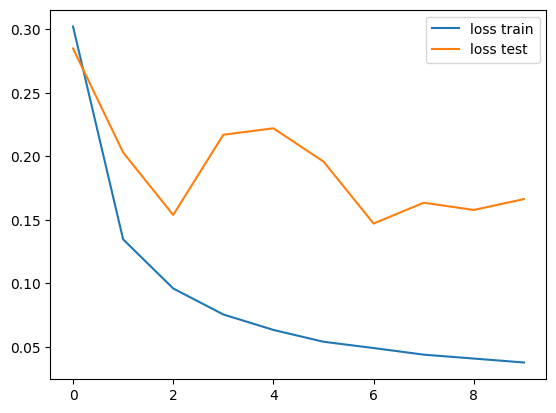

In [20]:
model = modele_type_1(128,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = 10,lr=1e-3,outmodelname='../models/model_DNN_1_50000_128_RELU_validationonTestDB.pkl')


#### 4.1.4 : start: 128 neurons using leakyReLU activation

##### train / crossval 

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─LeakyReLU: 1-2                         --
├─Linear: 1-3                            16,512
├─LeakyReLU: 1-4                         --
├─Linear: 1-5                            8,256
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/10 -- Training loss 0.2828048510441421, --- Val loss 0.15384680032730103, --- accuray : 0.9461284491704467, --- recall : 0.9464068292925543
save model
Epoch : 2/10 -- Training loss 0.12238935045879727, --- Val loss 0.10096687823534012, --- accuray : 0.9655669259120726, --- recall : 0.9652375859523457
save model
Epoch : 3/10 -- Training loss 0.08882505692442286, --- Val loss 0.09297548979520798, --- accuray : 0.9671980525176525, --- recall : 0.9669570540553266
save model
Epoch : 4/10 -- Training loss 0.07066903849061866, --- Val loss 0

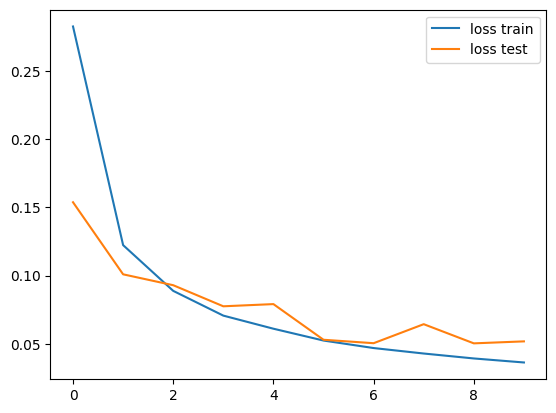

In [21]:
model = modele_type_1(128,activation=nn.LeakyReLU)
train_a_model(model,train_loader,cross_set,epochs = 10,lr=1e-3,outmodelname='../models/model_DNN_1_50000_128_LEAKYRELU.pkl')

##### eval on test

In [22]:
model=joblib.load('../models/model_DNN_1_50000_128_LEAKYRELU.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17403  267   299   95    54
1             76  458    20    0     2
2             23   10  1382   29     4
3             10    0    13  138     1
4             12    4    10    1  1581
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     18118
           1       0.62      0.82      0.71       556
           2       0.80      0.95      0.87      1448
           3       0.52      0.85      0.65       162
           4       0.96      0.98      0.97      1608

    accuracy                           0.96     21892
   macro avg       0.78      0.91      0.84     21892
weighted avg       0.97      0.96      0.96     21892



#### 4.1.5 : start: 128 neurons using leakyReLU activation long epoch test

##### train / crossval 

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─LeakyReLU: 1-2                         --
├─Linear: 1-3                            16,512
├─LeakyReLU: 1-4                         --
├─Linear: 1-5                            8,256
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/50 -- Training loss 0.28581294839899646, --- Val loss 0.1489994078874588, --- accuray : 0.9490934609129539, --- recall : 0.9492580618961307
save model
Epoch : 2/50 -- Training loss 0.12530040316678018, --- Val loss 0.11635233461856842, --- accuray : 0.9590575471323224, --- recall : 0.9587215955170294
save model
Epoch : 3/50 -- Training loss 0.08780553238866344, --- Val loss 0.08494342118501663, --- accuray : 0.9702234213215994, --- recall : 0.9703050474057164
save model
Epoch : 4/50 -- Training loss 0.07009971987355534, --- Val loss 0

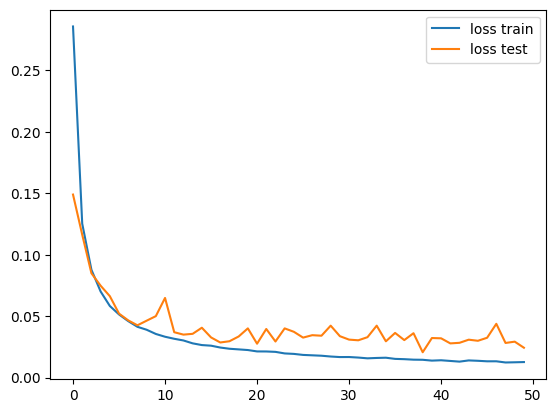

In [44]:
model = modele_type_1(128,activation=nn.LeakyReLU)
train_a_model(model,train_loader,cross_set,epochs = 50,lr=1e-3,outmodelname='../models/model_DNN_1_50000_128_LEAKYRELU_50_epochs.pkl')

##### eval on test

In [24]:
model=joblib.load('../models/model_DNN_1_50000_128_LEAKYRELU_50_epochs.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17532  248   129  171    38
1             81  456    11    7     1
2             27   11  1370   38     2
3             11    0     7  143     1
4             18    3     5    1  1581
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.64      0.82      0.72       556
           2       0.90      0.95      0.92      1448
           3       0.40      0.88      0.55       162
           4       0.97      0.98      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.78      0.92      0.83     21892
weighted avg       0.97      0.96      0.97     21892



### 4.2 Modele 2 - 50 000 * 5 classes <a class="anchor" name="m2_50000"></a>

##### train / crossval 

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,032
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            4,160
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 20,677
Trainable params: 20,677
Non-trainable params: 0
save model
Epoch : 1/10 -- Training loss 0.35652152356572026, --- Val loss 0.2046193927526474, --- accuray : 0.9279589243609131, --- recall : 0.9247165915648823
save model
Epoch : 2/10 -- Training loss 0.17014144372135717, --- Val loss 0.1489650458097458, --- accuray : 0.9470791780040099, --- recall : 0.9467166456531677
save model
Epoch : 3/10 -- Training loss 0.12306997323758043, --- Val loss 0.12047139555215836, --- accuray : 0.9590027149794953, --- recall : 0.9585691762054089
save model
Epoch : 4/10 -- Training loss 0.09878730976950456, --- Val loss 0.0

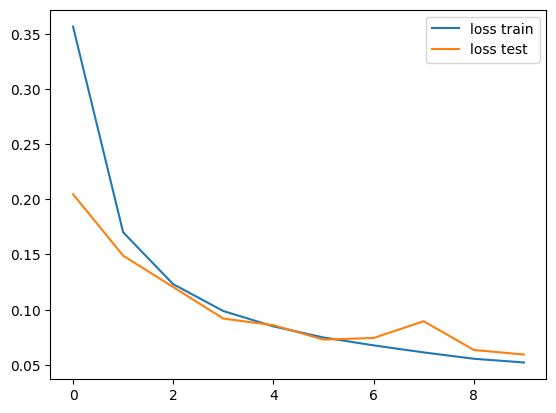

In [25]:
model = modele_type_2(64,activation=nn.ReLU)
train_a_model(model,train_loader,cross_set,epochs = 10,lr=1e-3,outmodelname='../models/model_DNN_2_50000.pkl')

##### eval on test

In [26]:
model=joblib.load('../models/model_DNN_2_50000.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17331  517   157   68    45
1             77  467     9    2     1
2             28   12  1379   26     3
3             14    0    10  138     0
4             17    5     6    1  1579
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     18118
           1       0.47      0.84      0.60       556
           2       0.88      0.95      0.92      1448
           3       0.59      0.85      0.70       162
           4       0.97      0.98      0.98      1608

    accuracy                           0.95     21892
   macro avg       0.78      0.92      0.83     21892
weighted avg       0.97      0.95      0.96     21892



### 4.3 Modele 3 - 50 000 * 5 classes <a class="anchor" name="m3_50000"></a>

##### train / crossval 

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,032
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            4,160
├─ReLU: 1-6                              --
├─Linear: 1-7                            4,160
├─ReLU: 1-8                              --
├─Linear: 1-9                            4,160
├─ReLU: 1-10                             --
├─Linear: 1-11                           4,160
├─ReLU: 1-12                             --
├─Linear: 1-13                           325
Total params: 33,157
Trainable params: 33,157
Non-trainable params: 0
save model
Epoch : 1/10 -- Training loss 0.39056524149748856, --- Val loss 0.23653466999530792, --- accuray : 0.9173934053361192, --- recall : 0.9164944032318392
save model
Epoch : 2/10 -- Training loss 0.17971627288326825, --- Val loss 0.13801778852939606, --- accuray : 0.952577956421778

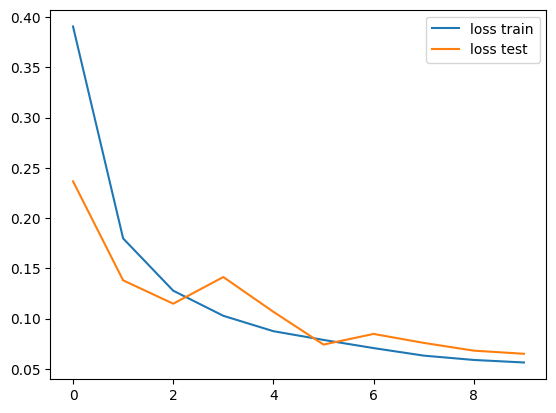

In [27]:
model = modele_type_3(64,5,activation=nn.ReLU)
train_a_model(model,train_loader,cross_set,epochs = 10,lr=1e-3,outmodelname='../models/model_DNN_3_50000.pkl')

##### eval on test

In [28]:
model=joblib.load('../models/model_DNN_3_50000.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17288  511   210   69    40
1             73  468    12    1     2
2             33   13  1377   21     4
3              9    1    13  139     0
4             12   12    12    5  1567
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     18118
           1       0.47      0.84      0.60       556
           2       0.85      0.95      0.90      1448
           3       0.59      0.86      0.70       162
           4       0.97      0.97      0.97      1608

    accuracy                           0.95     21892
   macro avg       0.77      0.92      0.83     21892
weighted avg       0.97      0.95      0.96     21892



### 4.4 TEST Autre type

In [29]:
model = nn.Sequential(
       nn.Linear(187, 50),
       nn.LeakyReLU(),
       nn.Linear(50, 24),
       nn.LeakyReLU(),
       nn.Linear(24, 24),
       nn.LeakyReLU(),
       nn.Linear(24, 24),
       nn.LeakyReLU(),
       nn.Linear(24 , 5)
    )   
model.to("cpu")
summary(model, input_size=(187,), device="cpu")

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            9,400
├─LeakyReLU: 1-2                         --
├─Linear: 1-3                            1,224
├─LeakyReLU: 1-4                         --
├─Linear: 1-5                            600
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            600
├─LeakyReLU: 1-8                         --
├─Linear: 1-9                            125
Total params: 11,949
Trainable params: 11,949
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            9,400
├─LeakyReLU: 1-2                         --
├─Linear: 1-3                            1,224
├─LeakyReLU: 1-4                         --
├─Linear: 1-5                            600
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            600
├─LeakyReLU: 1-8                         --
├─Linear: 1-9                            125
Total params: 11,949
Trainable params: 11,949
Non-trainable params: 0

##### train / crossval 

save model
Epoch : 1/50 -- Training loss 0.012625954654263324, --- Val loss 0.02929733879864216, --- accuray : 0.9934288244543339, --- recall : 0.993389271957642
save model
Epoch : 2/50 -- Training loss 0.011702917723579127, --- Val loss 0.031281646341085434, --- accuray : 0.9943639286519202, --- recall : 0.994361140803948
Epoch : 3/50 -- Training loss 0.012444328451918863, --- Val loss 0.032548923045396805, --- accuray : 0.9929501473112886, --- recall : 0.9929252226537084
save model
Epoch : 4/50 -- Training loss 0.011953702082221204, --- Val loss 0.026508044451475143, --- accuray : 0.9951750434539413, --- recall : 0.9951757954485038
Epoch : 5/50 -- Training loss 0.012427812329664186, --- Val loss 0.03595719486474991, --- accuray : 0.9925806318456069, --- recall : 0.9925043501297395
Epoch : 6/50 -- Training loss 0.011137058614307284, --- Val loss 0.03968648985028267, --- accuray : 0.9910037190758232, --- recall : 0.9909587329973455
save model
Epoch : 7/50 -- Training loss 0.01105488237

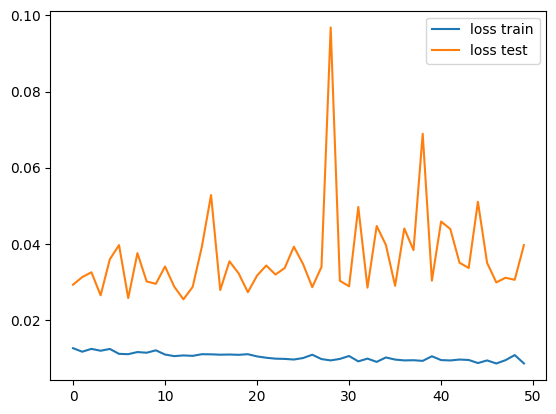

In [47]:
train_a_model(model,train_loader,cross_set,epochs = 50,lr=1e-3,outmodelname='../models/model_DNN_4_50000.pkl')

##### eval on test

In [48]:
model=joblib.load('../models/model_DNN_4_50000.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17830  146    84   34    24
1             88  459     7    1     1
2             41    7  1376   22     2
3             17    0    12  133     0
4             17    2     7    0  1582
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.75      0.83      0.78       556
           2       0.93      0.95      0.94      1448
           3       0.70      0.82      0.76       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.87      0.91      0.89     21892
weighted avg       0.98      0.98      0.98     21892



## 5. TEST AVEC QUE DU RESAMPLING SMOTE <a class="anchor" name="smote"></a>


In [32]:
from imblearn.over_sampling import SMOTE


In [38]:
X1,y1 = load_balanced.load('../data/raw/mitbih_train.csv')
sm = SMOTE(random_state=123) 
X_rs, y_rs = sm.fit_resample(X1 ,y1)

X_train, X_cross, y_train, y_cross = train_test_split(X_rs, y_rs,random_state=12,test_size = 0.05)
train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
cross_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))

test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))
train_loader = DataLoader(train_set, batch_size=30, shuffle=True)

### 5.1 LeakyReLU

##### train / crossval 

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─LeakyReLU: 1-2                         --
├─Linear: 1-3                            16,512
├─LeakyReLU: 1-4                         --
├─Linear: 1-5                            8,256
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/10 -- Training loss 0.21561828972540456, --- Val loss 0.1125103160738945, --- accuray : 0.9595940740495875, --- recall : 0.9588991727453692
save model
Epoch : 2/10 -- Training loss 0.08639457318851926, --- Val loss 0.0803958922624588, --- accuray : 0.9724673305959779, --- recall : 0.9720337224064975
save model
Epoch : 3/10 -- Training loss 0.0618998644541247, --- Val loss 0.05015368387103081, --- accuray : 0.9839047071822895, --- recall : 0.983968867502756
save model
Epoch : 4/10 -- Training loss 0.04951443941694771, --- Val loss 0.04

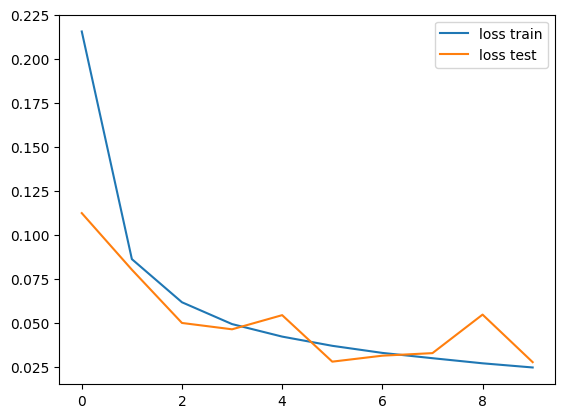

In [34]:
model = modele_type_1(128,activation=nn.LeakyReLU)
train_a_model(model,train_loader,cross_set,epochs = 10,lr=1e-3,outmodelname='../models/model_DNN_1_50000_128_LEAKYRELU_smoteonly.pkl')

##### eval on test

In [35]:
model=joblib.load('../models/model_DNN_1_50000_128_LEAKYRELU_smoteonly.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17859  126    78   17    38
1            102  444     6    3     1
2             42    9  1367   23     7
3             18    0    10  134     0
4             17    6     5    3  1577
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.76      0.80      0.78       556
           2       0.93      0.94      0.94      1448
           3       0.74      0.83      0.78       162
           4       0.97      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.88      0.91      0.89     21892
weighted avg       0.98      0.98      0.98     21892



### 5.2 ReLU

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─ReLU: 1-2                              --
├─Linear: 1-3                            16,512
├─ReLU: 1-4                              --
├─Linear: 1-5                            8,256
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/10 -- Training loss 0.22325682861109575, --- Val loss 0.10464052110910416, --- accuray : 0.9632037188881316, --- recall : 0.9634966978367924
save model
Epoch : 2/10 -- Training loss 0.08997589178657776, --- Val loss 0.06445742398500443, --- accuray : 0.9787024464976477, --- recall : 0.9786685565944818
save model
Epoch : 3/10 -- Training loss 0.0642165597215927, --- Val loss 0.048481397330760956, --- accuray : 0.9840114854025336, --- recall : 0.9840394066169923
Epoch : 4/10 -- Training loss 0.051138570248423255, --- Val loss 0.04762233

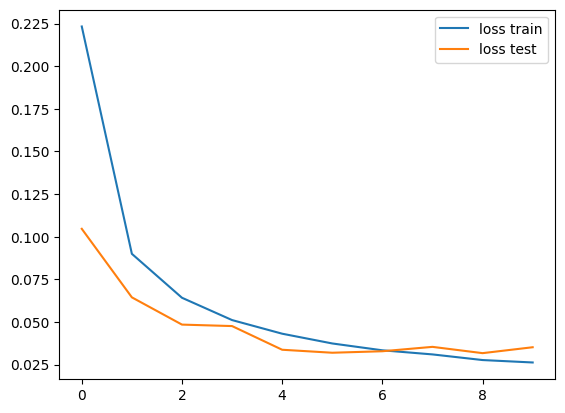

In [39]:
model = modele_type_1(128,activation=nn.ReLU)
train_a_model(model,train_loader,cross_set,epochs = 10,lr=1e-3,outmodelname='../models/model_DNN_1_50000_128_RELU_smoteonly.pkl')

In [40]:
model=joblib.load('../models/model_DNN_1_50000_128_RELU_smoteonly.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17497  273   231   74    43
1             91  445    15    3     2
2             25   14  1376   25     8
3             11    1    10  140     0
4             14    5     6    2  1581
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.60      0.80      0.69       556
           2       0.84      0.95      0.89      1448
           3       0.57      0.86      0.69       162
           4       0.97      0.98      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.80      0.91      0.84     21892
weighted avg       0.97      0.96      0.96     21892



### 5.1 LeakyReLU 50 epochs

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─ReLU: 1-2                              --
├─Linear: 1-3                            16,512
├─ReLU: 1-4                              --
├─Linear: 1-5                            8,256
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/50 -- Training loss 0.22935521137015996, --- Val loss 0.13314877450466156, --- accuray : 0.9545484363744567, --- recall : 0.9543583212322322
save model
Epoch : 2/50 -- Training loss 0.09169012455559337, --- Val loss 0.07100854068994522, --- accuray : 0.9755744527326471, --- recall : 0.9746799835498656
save model
Epoch : 3/50 -- Training loss 0.06517126203759133, --- Val loss 0.048986468464136124, --- accuray : 0.9827332997944591, --- recall : 0.9828408785595361
save model
Epoch : 4/50 -- Training loss 0.052168749788917314, --- Val los

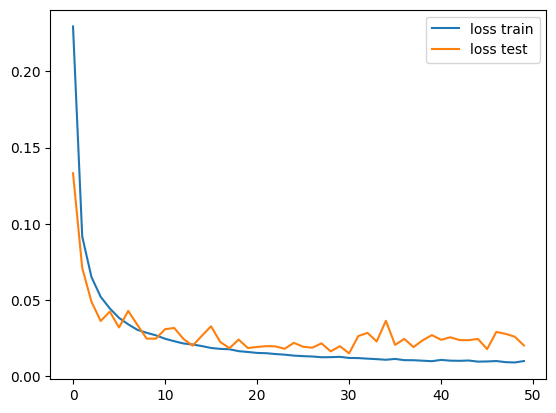

In [41]:
model = modele_type_1(128,activation=nn.ReLU)
train_a_model(model,train_loader,cross_set,epochs = 50,lr=1e-3,outmodelname='../models/model_DNN_1_50000_128_RELU_smoteonly_50_epochs.pkl')

In [42]:
model=joblib.load('../models/model_DNN_1_50000_128_RELU_smoteonly_50_epochs.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17914  107    63   11    23
1            106  436    10    2     2
2             55   10  1361   16     6
3             22    1    10  129     0
4             17    4     5    1  1581
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.78      0.78      0.78       556
           2       0.94      0.94      0.94      1448
           3       0.81      0.80      0.80       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.90      0.90      0.90     21892
weighted avg       0.98      0.98      0.98     21892



## 6. Finalisation<a class="anchor" name="results"></a>


les meilleurs résultats sembre etre pour le model 1 avec ReLU sur le dataset resamplé par smote, (deception...)

### 6.1 50 000

In [49]:
X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')


X_train, X_cross, y_train, y_cross = train_test_split(X_train, y_train,random_state=12,test_size = 0.05)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
cross_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))
test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─ReLU: 1-2                              --
├─Linear: 1-3                            16,512
├─ReLU: 1-4                              --
├─Linear: 1-5                            8,256
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/50 -- Training loss 0.37706912182506763, --- Val loss 0.211806058883667, --- accuray : 0.9253131749784194, --- recall : 0.9234559235675521
save model
Epoch : 2/50 -- Training loss 0.17184138815026534, --- Val loss 0.15290024876594543, --- accuray : 0.9475851043072112, --- recall : 0.946414243660078
save model
Epoch : 3/50 -- Training loss 0.12170677203488978, --- Val loss 0.10086364299058914, --- accuray : 0.9635645183910538, --- recall : 0.9635898882569215
save model
Epoch : 4/50 -- Training loss 0.09646028168185761, --- Val loss 0.0

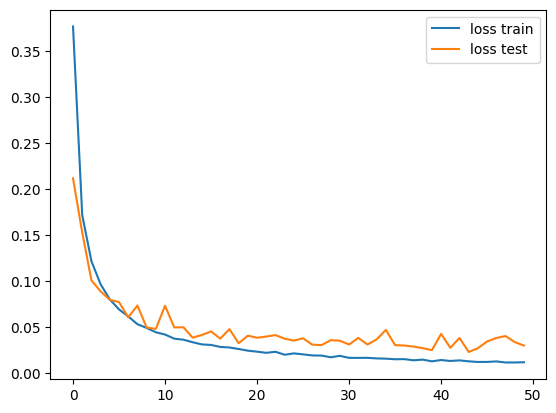

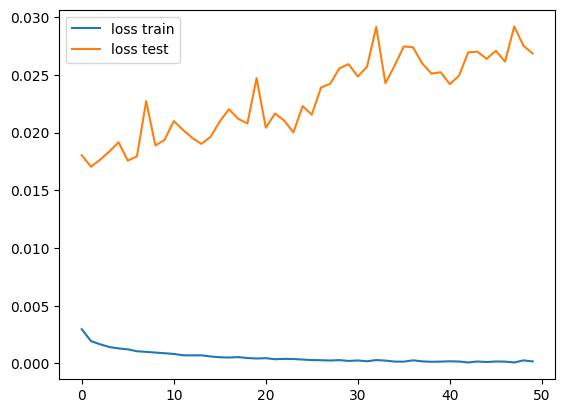

In [50]:
model = modele_type_1(128,activation=nn.ReLU)
train_a_model(model,train_loader,cross_set,epochs = 50,lr=1e-3,outmodelname='../models/model_DNN_1_50000_128_RELU_final_.pkl')
train_a_model(model,train_loader,cross_set,epochs = 50,lr=1e-4,outmodelname='../models/model_DNN_1_50000_128_RELU_final_.pkl')

In [51]:
model=joblib.load('../models/model_DNN_1_50000_128_RELU_final_.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17922  104    61   11    20
1             97  444    11    2     2
2             34    6  1384   20     4
3             19    0    11  132     0
4             15    3     8    1  1581
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.80      0.80      0.80       556
           2       0.94      0.96      0.95      1448
           3       0.80      0.81      0.80       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.90      0.91      0.90     21892
weighted avg       0.98      0.98      0.98     21892



### 6.2 SMOTE

In [52]:
X1,y1 = load_balanced.load('../data/raw/mitbih_train.csv')
sm = SMOTE(random_state=123) 
X_rs, y_rs = sm.fit_resample(X1 ,y1)

X_train, X_cross, y_train, y_cross = train_test_split(X_rs, y_rs,random_state=12,test_size = 0.05)
train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
cross_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))

test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─ReLU: 1-2                              --
├─Linear: 1-3                            16,512
├─ReLU: 1-4                              --
├─Linear: 1-5                            8,256
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
save model
Epoch : 1/50 -- Training loss 0.2957201264831101, --- Val loss 0.16638827323913574, --- accuray : 0.9427340758681082, --- recall : 0.9376580818961575
save model
Epoch : 2/50 -- Training loss 0.11733002311975033, --- Val loss 0.09277612715959549, --- accuray : 0.968225512856006, --- recall : 0.9678340494596485
save model
Epoch : 3/50 -- Training loss 0.08121453655933442, --- Val loss 0.07516081631183624, --- accuray : 0.9731033713873286, --- recall : 0.9727835207929955
save model
Epoch : 4/50 -- Training loss 0.06259739114785247, --- Val loss 0.

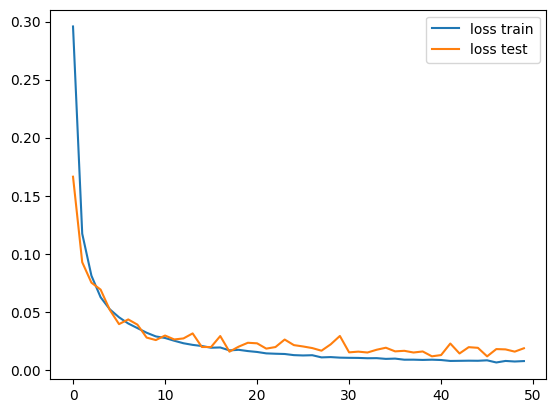

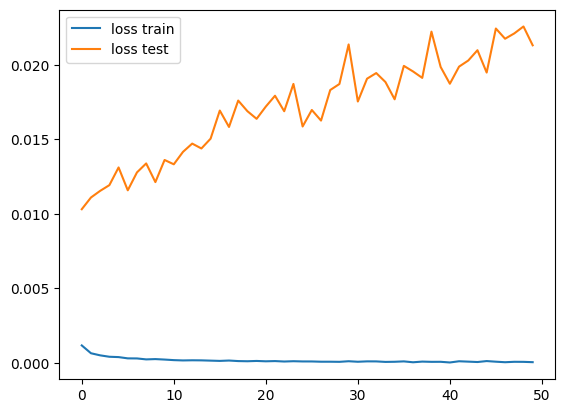

In [53]:
model = modele_type_1(128,activation=nn.ReLU)
train_a_model(model,train_loader,cross_set,epochs = 50,lr=1e-3,outmodelname='../models/model_DNN_1_smote_128_RELU_final_.pkl')
train_a_model(model,train_loader,cross_set,epochs = 50,lr=1e-4,outmodelname='../models/model_DNN_1_smote_128_RELU_final_.pkl')

In [54]:
model=joblib.load('../models/model_DNN_1_smote_128_RELU_final_.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17976   87    31   13    11
1            107  437    11    0     1
2             54    7  1366   18     3
3             21    0    14  127     0
4             26    1     3    0  1578
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.82      0.79      0.80       556
           2       0.96      0.94      0.95      1448
           3       0.80      0.78      0.79       162
           4       0.99      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.91      0.90      0.90     21892
weighted avg       0.98      0.98      0.98     21892



le modele sur dataset 50000 loupe moins de malades

In [62]:
model=joblib.load('../models/model_DNN_1_50000_128_RELU_final_.pkl')


In [63]:
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)

table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])

In [64]:
N_sains = table.loc[0,:].sum()
N_malades = table.sum().sum() - N_sains
print('total sains:'  ,N_sains)
print('total Malades:'  ,N_malades)
N_malades_non_detectes = table[0].iloc[1::].sum()

N_sains_mais_dits_malades = table.loc[0].iloc[1::].sum()
print('malades non détectés:' , N_malades_non_detectes , '(%.1f' % ( N_malades_non_detectes/N_malades*100) ,'%)')
print('sains envoyés en examen:' , N_sains_mais_dits_malades , '(%.1f' % (N_sains_mais_dits_malades/N_sains*100) ,'%)')

total sains: 18118
total Malades: 3774
malades non détectés: 165 (4.4 %)
sains envoyés en examen: 196 (1.1 %)


## base Ptbdb

In [67]:
X2,y2 = load_balanced.load('../data/raw/ptbdb_abnormal.csv')

In [73]:
abnormal_set = TensorDataset(torch.from_numpy(X2).float(), torch.Tensor(torch.from_numpy(y2).long()))
abnormal_setX,_ = abnormal_set[:]
model.eval()
with torch.no_grad():
    # Prédiction du modèle pour un batch donné
    y_pred = model(abnormal_setX)

    
y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
print(pd.Series(y_pred).value_counts())

0    8427
2     802
4     610
1     601
3      66
Name: count, dtype: int64


In [74]:
X2,y2 = load_balanced.load('../data/raw/ptbdb_normal.csv')

abnormal_set = TensorDataset(torch.from_numpy(X2).float(), torch.Tensor(torch.from_numpy(y2).long()))
abnormal_setX,_ = abnormal_set[:]
model.eval()
with torch.no_grad():
    # Prédiction du modèle pour un batch donné
    y_pred = model(abnormal_setX)

    
y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
print(pd.Series(y_pred).value_counts())

0    3648
1     238
2     133
3      24
4       3
Name: count, dtype: int64
